# H + COOH Coverage

#### Imports

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import csv
import time
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import random

np.random.seed(1)

In [5]:
sys.path.append('../scripts')
from functions import *

#### Load energy prediction models

In [6]:
# Load energy (G) prediction models
models = load_G_models()

#### Setup

In [7]:
# Size of the surface
dim_x, dim_y = 200, 200

# Metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
split =  [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]
site_types = {"H": "ads_hol", "COOH": "ads_top", "OH": "ads_top", "O": "ads_hol"}
# Should I have a toggle-thing, where I can disable each adsorbate seperately?

# Other parameters (Coming)
CO_reaction = True # Make the *H+*COOH -> *CO + H2O reaction, when *H+*COOH pair is found
Oxidation_reaction_O = True
# Toggle for removal of CO at high potentials? - Done by OH or O I guess

# Voltages
#start = 0.025
#end = 1.05
start = -0.5
end   = 1.25
scan_rate = 0.005

# I should have parameters to control whether reactions take place, etc.

## Define the simulation name for the log file
log_folder = "../Coverage_logs/"
simulation_name = "CO_O_oxidation_HEA_SWR_models"

### Run the simulation
#### Seperate H and COOH - Precompute all binding energies 

## Simple simulation - only H and COOH independantly

In [ ]:
## Create the log file with column names
column_names = ['Adsorbate', 'Action', 'Gibbs E', 'Border_voltage', 'Voltage', 'Index x', 'Index y', 'site_type', 'Timestamp']
create_log_file(log_folder + simulation_name + ".csv", column_names)

## Create the surface with: 'atoms', 'ads_top', 'ads_hol', 'COOH_G', 'H_G', 'COOH_V', 'H_V'
surface = initialize_surface(dim_x, dim_y, metals, split) # Combined with the occupance matrix in a dictionary # I should have options to change the surface

## Initialize the statistics log
statistics_log = initialize_statistics_log() # Maybe I should initialize the surface with H, so it doesn't write 10.000 lines each time it boots up

## Precompute all binding energies
surface = precompute_binding_energies_SPEED(surface, dim_x, dim_y, models, predict_G) #Updated to the speedy predictions - TJEK add OH and O then we are good. Make sure the names in the dict match up
start_time = time.time()
## Set a voltage ### Should I put this in a wrapper function like with the predicting binding energies?
for voltage in tqdm(voltage_sweep(start, end, scan_rate), desc = "Varying voltage"): # Approximates the desired scan rate
    
    ## Look through the whole surface, both adsorbates, and ad/desorb as it should and log actions in log file
    surface = look_at_all_sites_and_adsorbates(surface, dim_x, dim_y, site_types, voltage) ## I REMOVE or ADD stuff right here for simplicity
    
    ## Reaction: *H+*COOH -> *CO + H2O
    ## Maybe I should have a list of toggleable reactions
    if CO_reaction == True:
        surface = decision_to_react_CO(surface)
    if Oxidation_reaction_O == True:
        surface = decision_to_react_O(surface)
    
    ## Log stats of the surface # Voltage, n_H, n_COOH, n_neighbours
    statistics_log = count_statistics(surface, voltage, statistics_log)
    

#### Plot the statistics

Ideas for statistics / data visualisation

Plot with how many H and COOH there are on the surface at each voltage

Gif with a number that shows the voltage and a surface, with "H" and "COOH" shown on the surface

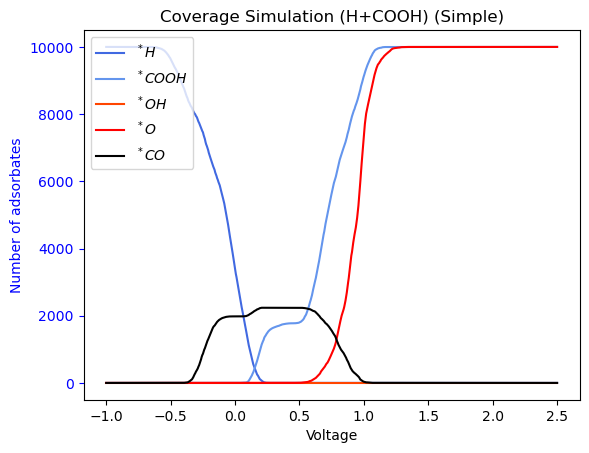

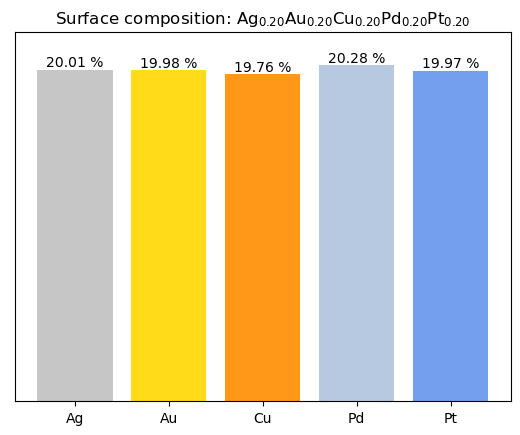

In [44]:
plot_statistics_log(statistics_log, simulation_name, mode = "plain") # I need a plot_statistics_log option to show *CO
plot_surface_composition(metals, surface["atoms"])

## 

### Functions for initializing and running the coverage simulation

(To be moved to seperate .py file)

In [42]:
def initialize_surface_coverage_simulation(dim_x, dim_y, metals, split): #Is still random - could be used with a seed in the name of reproduceability
    dim_z = 3
    #surface_list = np.array([int(dim_x*dim_y*dim_z/len(metals))*[metals[metal_number]] for metal_number in range(len(metals))]).flatten() #Jack had a way shorter way of doing this, but I think it was random drawing instead of ensuring a perfectly even split
    #np.random.shuffle(surface_list) #Shuffle list
    #surf_atoms = np.reshape(surface_list, (dim_x, dim_y, dim_z)) #Reshape list to the
    
    surf_atoms = create_surface(dim_x, dim_y, metals, split)
    
    # Adsorbates
    surf_ads_top = np.reshape(["empty"]*dim_x*dim_y, (dim_x, dim_y))
    surf_ads_hol = np.reshape(["empty"]*dim_x*dim_y, (dim_x, dim_y))
    
    # Binding energies
    surf_COOH_G = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# On-top sites
    surf_H_G    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# Hollow sites
    surf_OH_G    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# On-top sites
    surf_O_G    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# Hollow sites
    
    # Ad/desorbs at voltage (At which voltage is the binding energy 0?)
    surf_COOH_V = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# On-top sites
    surf_H_V    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# # Hollow sites
    surf_OH_V    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# # Hollow sites
    surf_O_V    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# # Hollow sites
    
    surf = {"atoms": surf_atoms, "ads_top": surf_ads_top, "ads_hol": surf_ads_hol, \
            "COOH_G": surf_COOH_G, "H_G": surf_H_G, "OH_G": surf_OH_G, \
            "O_G": surf_O_G, "COOH_V": surf_COOH_V, "H_V": surf_H_V, \
            "OH_V": surf_OH_V, "O_V": surf_O_V} #This line had a but that took me two days to find... Pass by reference is such a smart feature (y)
    return surf

#def create_surface(dim_x, dim_y, metals, split):
#    dim_z = 3
#    num_atoms = dim_x*dim_y*dim_z
#    if split == "Even":
#        proba = [1.0 / len(metals) for n in range(len(metals))] 
#        surface = np.random.choice(metals, num_atoms, p=proba)
#    else:
#        surface = np.random.choice(metals, num_atoms, p=split)
#    surface = np.reshape(surface, (dim_x, dim_y, dim_z))
#    return surface

#def voltage_sweep(start, end, scan_rate):
#    return np.linspace(start, end, int(np.abs(start - end) / scan_rate))

#def voltage_circle
#def voltage_up_down (All these could be worked into a single function)

#def calc_V_border(ads, G):
#    """This function returns the border-voltage, at which the adsorbate adsorbs or desorbs"""
#    
#    if ads == "H":
#        V_border = - G  # Lille boost #+ 0.7 # HER sætter jeg lige et boost ind, for at tjekke, om det fungerer, når *CO-reaktionen sker
#    if ads == "COOH":
#        V_border = G # TJEK er 0.7 et boost for at tjekke H+COOH -> CO + H2O reaktionen?
#    if ads == "OH":
#        V_border = G # Hvad er funktionen? Det samme som for COOH?
#    if ads == "O":
#        V_border = G/2 # Hvad er funktionen? Her hopper 2 elektroner af, så der sker noget andet
#    
#    return V_border

#def precompute_binding_energies(surface, dim_x, dim_y, models, predict_G_function):
#    for x, y in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # I could randomise this, so I go through all sites in a random order
#        ## What is the binding energy # With more adsorbates in future can be exchanged for a loop through the adsorbates
#        ads = "H"
#        surface["H_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["H_V"][x][y] = calc_V_border(ads = ads, G = surface["H_G"][x][y])
#        
#    for x, y in [(x, y) for x in range(dim_x) for y in range(dim_y)]:
#        ads = "COOH"
#        surface["COOH_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["COOH_V"][x][y] = calc_V_border(ads = ads, G = surface["COOH_G"][x][y])
#
#    return surface

#def precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G_function):
#    for x, y in tqdm([(x, y) for x in range(dim_x) for y in range(dim_y)], desc = r"Predicting all ΔG", leave = True): # I could randomise this, so I go through all sites in a random order
#        
#        # I'm pretty sure this can run like 8 times faster if I make it run in parallel - right now only takes 30 seconds, so not really worth spending a day building. Although I think this should be an easy example
#        # Oh, actually I'm not so sure, it looks like the CPU is already at 100%
#        ads = "H"
#        surface["H_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["H_V"][x][y] = calc_V_border(ads = ads, G = surface["H_G"][x][y])
#        
#        ads = "COOH"
#        surface["COOH_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["COOH_V"][x][y] = calc_V_border(ads = ads, G = surface["COOH_G"][x][y])
#        
#        ads = "OH"
#        surface["OH_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["OH_V"][x][y] = calc_V_border(ads = ads, G = surface["OH_G"][x][y])
#        
#        ads = "O"
#        surface["O_G"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
#        surface["O_V"][x][y] = calc_V_border(ads = ads, G = surface["O_G"][x][y])
#    return surface

#def create_log_file(file_name, column_names):
#    with open(file_name, 'w', newline='') as csvfile:
#        writer = csv.writer(csvfile)
#        writer.writerow(column_names)
#    return None

#def append_to_log_file(file_name, data):
#    with open(file_name, 'a', newline='') as csvfile:
#        writer = csv.writer(csvfile)
#        writer.writerow(data)
#    return None

#def look_at_all_sites_and_adsorbates(surface, dim_x, dim_y, site_types, voltage):
#    
#    ## Look through all sites (not bridge sites yet) by index
#    for site_x, site_y in [(x, y) for x in range(dim_x) for y in range(dim_y)]:
#        
#        ## Look through all adsorbates and their respective adsorption sites
#        for ads, site_type in [(ads, site_types[ads]) for ads in ["H", "COOH", "OH", "O"]]: 
#            #print(site_x, site_y, ads, site_type)
#            
#            # Make the decision to adsorb/desorb or do nothing with this function:
#            surface = decision_to_leave(surface, site_x, site_y, ads, site_type, voltage)
#    
#    return surface

#def decision_to_leave(surface, site_x, site_y, ads, site_type, voltage):
#    ## Figure out if anything should be ad or desorbed
#    
#    # Is the adsorbate sitting at the site already?
#    contents_of_site = surface[site_type][site_x][site_y]
#    is_ads_there = contents_of_site != "empty"
#    
#    # Should the adsorbate be there? #tested, seems to work
#    V_border = surface[ads+"_V"][site_x][site_y]
#    
#    # H adsorbs when the voltage is BELOW the border voltage
#    if ads == "H":
#        supposed_to = voltage < V_border
#    
#    # COOH adsorbs when the voltage is ABOVE the border voltage
#    if ads in ["COOH", "OH", "O"]:
#        supposed_to = voltage > V_border
#    
#    if (is_ads_there == False) and (supposed_to == True):
#        # Adsorb
#        surface[site_type][site_x][site_y] = ads
#        
#        # Save line to log file
#        append_to_log_file(log_folder + simulation_name + ".csv", [ads, "adsorb", surface[ads+"_G"][site_x, site_y], surface[ads+"_V"][site_x, site_y], voltage, site_x, site_y, site_type, time.time() - start_time])
#        
#    if (is_ads_there == True) and (supposed_to == False):
#        # Desorb
#        surface[site_type][site_x][site_y] = "empty"
#        
#        # Save line to log file
#        append_to_log_file(log_folder + simulation_name + ".csv", [ads, "desorption", surface[ads+"_G"][site_x, site_y], surface[ads+"_V"][site_x, site_y], voltage, site_x, site_y, site_type, time.time() - start_time])
#    return surface

# Revamping the function to accomodate for several types of adsorbates on the same site.
#def decision_to_leave(surface, site_x, site_y, ads, site_type, voltage):
#    ## Figure out if anything should be ad or desorbed
#    
#    # Is the adsorbate sitting at the site already?
#    contents_of_site = surface[site_type][site_x][site_y]
#    #is_ads_there = contents_of_site != "empty"
#    
#    # Should the adsorbate be there? #tested, seems to work
#    V_border = surface[ads+"_V"][site_x][site_y]
#    
#    # H adsorbs when the voltage is BELOW the border voltage
#    if ads == "H":
#        supposed_to = voltage < V_border
#    
#    # COOH adsorbs when the voltage is ABOVE the border voltage
#    if ads in ["COOH", "OH", "O"]:
#        supposed_to = voltage > V_border
#    
#    # IFF the site is empty AND the adsorbate is supposed to be there, ADSORB
#    if (contents_of_site == "empty") and (supposed_to == True): #Should check if the adsorbate there is == the adsorbate we're looking at
#        # Adsorb
#        surface[site_type][site_x][site_y] = ads
#        
#        # Save line to log file
#        append_to_log_file(log_folder + simulation_name + ".csv", [ads, "adsorb", surface[ads+"_G"][site_x, site_y], surface[ads+"_V"][site_x, site_y], voltage, site_x, site_y, site_type, time.time() - start_time])
#    
#    # IFF the adsorbate is sitting at the site, and it shouldn't be, DESORB
#    if (contents_of_site == ads) and (supposed_to == False): #ahh, this line made OH try to remove a COOH
#        # Desorb
#        surface[site_type][site_x][site_y] = "empty"
#        
#        # Save line to log file
#        append_to_log_file(log_folder + simulation_name + ".csv", [ads, "desorption", surface[ads+"_G"][site_x, site_y], surface[ads+"_V"][site_x, site_y], voltage, site_x, site_y, site_type, time.time() - start_time])
#    return surface

#def shuffle(liste):
#    #Shuffle the list
#    random.shuffle(liste)
#    return liste

#def neighbours(surface, x, y, x_diff, y_diff):
#    Top_site = surface["ads_top"][x][y]
#    FCC_neighbour = surface["ads_hol"][(x + x_diff) % dim_x][(y + y_diff) % dim_y]
#    
#    if Top_site == "COOH" and FCC_neighbour == "H":
#        return True
#    else:
#        return False

## Reactions!
# In the future, some functions could be combined in a neat way. Initially, I'll write them independently.

#def reaction_CO(surface, x, y, x_diff, y_diff): #So I need another 2 functions like this: CO + O -> CO2 and CO + OH -> CO2 + 
#    # Remove the *COOH
#    surface["ads_top"][x][y] = "empty"
#    append_to_log_file(log_folder + simulation_name + ".csv", ["COOH", "Make CO reaction", surface["COOH_G"][x, y], surface["COOH_V"][x, y], voltage, x, y, "ads_top", time.time() - start_time])
#    
#    # Remove the *H
#    surface["ads_hol"][x+x_diff][y+y_diff] = "empty"
#    append_to_log_file(log_folder + simulation_name + ".csv", ["H", "Make CO reaction", surface["H_G"][x, y], surface["H_V"][x, y], voltage, x, y, "ads_hol", time.time() - start_time])
#     
#    # Put a *CO instead of *COOH
#    surface["ads_top"][x][y] = "CO"
#    append_to_log_file(log_folder + simulation_name + ".csv", ["CO", "Make CO reaction", "n/a", "n/a", voltage, x+x_diff, y+y_diff, "ads_top", time.time() - start_time])
#    
#    return surface
#
#def decision_to_react_CO(surface):
#
#    # Look through all on-top sites for COOH species:
#    for x, y in shuffle([(x, y) for x in range(dim_x) for y in range(dim_y)]): # Mixed order
#        for x_diff, y_diff in shuffle([(0, 0), (0, -1), (-1, 0)]):             # Mixed order
#
#            if neighbours(surface, x, y, x_diff, y_diff): #Are there H + COOH neighbours?
#
#                surface = reaction_CO(surface, x, y, x_diff, y_diff)
#                
#                # Tjek - er det mon her de to/tre nye reaktioner skal tilføjes?
#    return surface     
#
#def decision_to_react_O(surface):
#    # Look through all on-top sites for CO species:
#    for x, y in shuffle([(x, y) for x in range(dim_x) for y in range(dim_y)]): # Mixed order
#        for x_diff, y_diff in shuffle([(1, -1), (-1, -1), (-1, 1)]):           # Mixed order
#            
#            # If we find CO at the top-site x, y AND O at the x+x_diff, y+y_diff hollow_site: Remove both
#            if (surface["ads_top"][x][y] == "CO") and (surface["ads_hol"][(x+x_diff) % dim_x][(y+y_diff) % dim_y] == "O"):
#                
#                #REACTION HAPPENS
#                # REMOVE BOTH ADSORBATES AND WRITE LOGS
#                # Remove the *CO
#                surface["ads_top"][x][y] = "empty"
#                append_to_log_file(log_folder + simulation_name + ".csv", ["CO", "CO oxidation", "n/a", "n/a", voltage, x, y, "ads_top", time.time() - start_time])
#    
#                # Remove the *O
#                surface["ads_hol"][(x+x_diff) % dim_x][(y+y_diff) % dim_y] = "empty"
#                append_to_log_file(log_folder + simulation_name + ".csv", ["O", "CO oxidation", "n/a", "n/a", voltage, (x+x_diff) % dim_x, (y+y_diff) % dim_y, "ads_hol", time.time() - start_time])
#     
#    return surface
                   
    # Find all pairs. This can be done with some of the lines from count_pairs
    
    # Make sure that if there is a H next to two COOHs, then it should only result in one *CO. Maybe check if the pair is still there before doing any reaction.
    
    # Including logging, when decisions are made

### Functions for statistics and data visualisation

Save something for each voltage:
- Number of n_H, n_COOH, n_pairs

In [23]:
def count_pairs(surface):
    '''This founction looks through a surface and returns the number of COOH + H pairs.
    It loops through all on-top sites, if there is a COOH, it looks at the neighbouring FCC sites
    If there'''
    pairs = 0
    # Look through all on-top sites for COOH species:
    for x, y in [(x, y) for x in range(dim_x) for y in range(dim_y)]:
        # Is there a COOH?
        if surface["ads_top"][x][y] == "COOH":
            # Are there any H on the neighbouring positions?
            for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:
                FCC_neighbour = surface["ads_hol"][(x + x_diff) % dim_x][(y + y_diff) % dim_y]
                if FCC_neighbour == "H":
                    pairs += 1          
    return pairs

def count_statistics(surface, voltage, statistics_log): # Should I input and return the statistics log each time or just append to it from inside the function? That's probably the way.
    '''This function counts some important metrics on the surface'''
    ## Log the voltage
    statistics_log["voltages"].append(voltage)
    
    ## Count number of the different adsorbates:
    # Count H adsorbates
    statistics_log["n_H"].append(np.count_nonzero(surface["ads_hol"] == 'H'))
    
    # Count COOH adsorbates
    statistics_log["n_COOH"].append(np.count_nonzero(surface["ads_top"] == 'COOH'))
    
    # Count COOH adsorbates
    statistics_log["n_OH"].append(np.count_nonzero(surface["ads_top"] == 'OH'))
    
    # Count COOH adsorbates
    statistics_log["n_O"].append(np.count_nonzero(surface["ads_hol"] == 'O'))
    
    # Count CO adsorbates
    statistics_log["n_CO"].append(np.count_nonzero(surface["ads_top"] == 'CO'))
    
    # Count H + COOH pairs
    statistics_log["n_pairs"].append(count_pairs(surface))
    
    return statistics_log

def initialize_statistics_log():
    statistics_log = {"voltages": [], "n_H": [], "n_COOH": [], "n_OH": [], "n_O": [], "n_CO": [], "n_pairs": []}
    return statistics_log

def plot_statistics_log(statistics_log, simulation_name, mode):
    fig, ax1 = plt.subplots()
    plt.title('Coverage Simulation (H+COOH) (Simple)')
    
    # Plot data on ax1
    line1 = ax1.plot(statistics_log["voltages"], statistics_log["n_H"], label="$^*H$", c="royalblue")
    line2 = ax1.plot(statistics_log["voltages"], statistics_log["n_COOH"], label="$^*COOH$", c="cornflowerblue")
    line3 = ax1.plot(statistics_log["voltages"], statistics_log["n_OH"], label="$^*OH$", c="orangered")
    line4 = ax1.plot(statistics_log["voltages"], statistics_log["n_O"], label="$^*O$", c="red")
    line5 = ax1.plot(statistics_log["voltages"], statistics_log["n_CO"], label="$^*CO$", c="black")
    
    ax1.set_xlabel('Voltage')
    ax1.set_ylabel('Number of adsorbates', color='blue')
    ax1.tick_params('y', colors='blue')
    
    #ax2 = ax1.twinx()
    
    #if mode == "pairs":
    #    # Plot data on ax2
    #    line5 = ax2.plot(statistics_log["voltages"], statistics_log["n_pairs"], label="$^*H$+$^*COOH$ pairs", c="tomato")
    #    ax2.set_ylabel('Number of H+COOH pairs', color='tab:red')
    #    lines = line1 + line2 + line3 + line4 + line5 
    #    
    #if mode == "CO":
    #    line5 = ax2.plot(statistics_log["voltages"], statistics_log["n_CO"], label="$^*CO$", c="tomato")
    #    ax2.set_ylabel('Number of $^*CO$ adsorbates', color='tab:red')
    #    lines = line1 + line2 + line3 + line4 + line5 
    #    
    #if mode == "plain":
    #    #do nothing (y)
    #    lines = line1 + line2 + line3 + line4
    #ax2.tick_params('y', colors='tab:red')
    
    # Combine the lines for the legend
    lines = line1 + line2 + line3 + line4 + line5 
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.savefig("../figures/coverage_simulations/"+simulation_name+".png", dpi=300, bbox_inches="tight")
    plt.show()
    return None

def plot_surface_composition(metals, surface):
    ### SURFACE COMPOSITION ###
    fig, ax_a = plt.subplots(1, 1, figsize = (6.4, 4.8))
    composition, composition_string = surface_composition(metals, surface)
    ymax = max(composition.values()) * 1.1
    ax_a.set_ylim(0, ymax)
    ax_a.set_title("Surface composition: " + composition_string)
    ax_a.set_yticks([])
    #ax.set_xticks([])
    bar1 = ax_a.bar(composition.keys(), composition.values(), alpha = 0.9, color = ["silver", "gold", "darkorange", "lightsteelblue", "cornflowerblue"])
    
    for idx, rect in enumerate(bar1):
        height = rect.get_height()
        fraction = list(composition.values())[idx]*100
        ax_a.text(rect.get_x() + rect.get_width() / 2.0, height, s = f"{fraction:.2f}" + " %", ha='center', va='bottom')
    return None

def surface_composition(metals, surface):
    composition = {}
    num_atoms = np.shape(surface)[0]*np.shape(surface)[1]*np.shape(surface)[2]
    
    for metal in metals:
        composition[metal] = np.count_nonzero(surface == metal) / num_atoms
        
    # Lav en kemisk formel for overfladen og lav subskript med deres fractions
    composition_string = ""

    for metal in metals:
        if composition[metal] > 0:
            composition_string += str(metal) + f"$_{{{composition[metal]:.2f}}}$"
    return composition, composition_string

### Predicting binding energies - These are replaced by the predict_energies_SPEED function, WHEN OH, O

In [7]:
def predict_G(surface, site_x, site_y, adsorbate, models):
    if adsorbate == "H":
        vector_df = pd.DataFrame([hollow_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(55)])
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["H"].predict(vector_DM)[0]
        return G
    
    if adsorbate == "O":
        vector_df = pd.DataFrame([hollow_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(55)]) # Tjek - er det ikke "adsorbate" + features?
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["O"].predict(vector_DM)[0]
        return G
    
    if adsorbate == "COOH":
        vector_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(20)]) # Tjek - er det ikke "adsorbate" + features?
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["COOH"].predict(vector_DM)[0]
        return G
    
    if adsorbate == "OH":
        vector_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(20)]) # Tjek - er det ikke "adsorbate" + features?
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["OH"].predict(vector_DM)[0]
        return G
    
    
    # Her kunne man lave et lækkert smart loop a la for ads in [hollow adsorbates]
    
    # Den her funktion skal bare udvides med de andre adsorbater
    
    # Bliver lidt sjovt med det mixed-site COOH + H
    
def predict_G_TEST(ads, site_x, site_y, surface, models):
    if ads == "H":
        G = np.random.normal(0.25, 0.50) #mean 0.25 eV 1 sigma spread omkring 0.5 eV
    if ads == "COOH":
        G = np.random.normal(1.53, 0.44)
    return G

def on_top_site_vector(surface, site_x, site_y): # I should have done modulo to dim_x and dim_y
    dim_x, dim_y = np.shape(surface)[0], np.shape(surface)[1]
    site1 = [surface[site_x, site_y, 0]]# Make a one-hot encoded vector of the very site here! Add at the beginning 
    site1_count = [site1.count(metals[n]) for n in range(len(metals))]
    
    top6 = [surface[site_x % dim_x, (site_y-1) % dim_y, 0], surface[site_x % dim_x, (site_y+1) % dim_y, 0], surface[(site_x-1) % dim_x, site_y % dim_y, 0], surface[(site_x+1) % dim_x, site_y % dim_y, 0], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 0]]
    top6_count = [top6.count(metals[n]) for n in range(len(metals))]
    
    mid3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y,1], surface[site_x % dim_x, (site_y-1) % dim_y,1], surface[(site_x-1) % dim_x, site_y % dim_y,1]]
    mid3_count = [mid3.count(metals[n]) for n in range(len(metals))]
    
    bot3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y, 2], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 2], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 2]]
    bot3_count = [bot3.count(metals[n]) for n in range(len(metals))]
    
    return site1_count + top6_count + mid3_count + bot3_count

metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
three_metals_combinations = [] #List of possible combinations of the three
# Der skal være 35, ikke 125

for a in metals:
    for b in metals:
        for c in metals:
            three_metals_combinations.append(''.join(sorted([a, b, c])))
            
# Remove duplicates
three_metals_combinations = list(dict.fromkeys(three_metals_combinations)) # Let's encode it in a better way later

def hollow_site_vector(surface, site_x, site_y): #Now with adsorbate encoding
    
    # First encode the 3 neighbours
    blues = [surface[(site_x+1) % dim_x, site_y, 0], surface[site_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y+1) % dim_y, 0]]
    blues = "".join(sorted(blues))
    idx = three_metals_combinations.index(blues)
    blues = 35*[0]
    blues[idx] = 1
    
    # Then the next neighbours (green)
    greens = [surface[(site_x+2) % dim_x, site_y, 0], surface[site_x, (site_y+2) % dim_y, 0], surface[site_x, site_y, 0]]
    greens_count = [greens.count(metals[n]) for n in range(len(metals))]
    
    # Then the next neighbours (brown) # Kunne gøres smartere med list comprehension og to lister med +- zipped
    browns = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, 2, 2, 1, -1, -1], [2, 1, -1, -1, 1, 2], [0, 0, 0, 0, 0, 0])]
    browns_count = [browns.count(metals[n]) for n in range(len(metals))]
    
    # Then the three downstairs neighbours
    yellows = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([0, 1, 0], [0, 0, 1], [1, 1, 1])]
    yellows_count = [yellows.count(metals[n]) for n in range(len(metals))]
    
    # Then the purples downstairs
    purples = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, -1, 1], [-1, 1, 1], [1, 1, 1])]
    purples_count = [purples.count(metals[n]) for n in range(len(metals))]
    
    return blues + greens_count + browns_count + yellows_count + purples_count

def pandas_to_DMatrix(df):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df, label=label)
    return DMatrix

def pandas_to_DMatrix(df):#, label):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df)#, label=label)
    return DMatrix

## Rewriting the decision to leave function

In [ ]:
def count_elements(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    counts_dict = dict(zip(unique_elements, counts))
    return counts_dict

count_elements(surface["ads_top"])

#### Just quickly checking how the energies look

In [30]:
import csv
import statistics

# Specify the file path and name
csv_file = '../csv_features/COOH_features.csv'

# Specify the target column header
target_column = "G_ads (eV)"

# Open the .csv file and read its contents using list comprehension
with open(csv_file, 'r') as file:
    # Create a CSV reader object
    reader = csv.DictReader(file)
    
    # Extract the values of the target column using list comprehension
    target_values = [float(row[target_column]) for row in reader]

# Calculate the mean and spread (standard deviation) of the target values
mean = statistics.mean(target_values)
spread = statistics.stdev(target_values)

# Print the mean and spread
print("Mean:", mean)
print("Spread (Standard Deviation):", spread)

Mean: 1.5326902202380952
Spread (Standard Deviation): 0.4410240645509031


In [28]:
import csv

# Specify the file path and name
csv_file = '../csv_features/COOH_features.csv'

# Open the .csv file and read its contents
with open(csv_file, 'r') as file:
    # Create a CSV reader object
    reader = csv.DictReader(file)
    
    # Extract the header names
    header_names = reader.fieldnames

# Now you have the header names in the header_names list


#### Logik

Oh shit, kunne man ikke bare predicte alle energier én gang? Det er simpelt i den model, hvor ingen nabointeraktioner tages med. Der skal også komme en model, som tager højde for H og COOH ved siden af hinanden. Men der kunne alle sites og så vinkel i alle retninger gemmes i et look-up table. Så predicter man først alle energier én gang, og så har man bare gemt en matrix med de spændinger, som ville få et adsorbat til at hoppe på/af.

Måske gem alle.

I surface dict kan jeg bare gemme ekstra lag, som hedder H_G, H_Voltage (hvor hvis voltage er UNDER hopper den på) og samme med COOH_G og COOH_Voltage (Hvor hvis voltage er OVER hopper den på) Så kan alt det preprocessing laves inden man "kører simulationen", som så bliver utroligt simpelt. Oh shit et speedup det kan blive til.

Hvad er logikken når man sætter en *H ved siden af en *COOH eller en *COOH ved siden af en *H?
Skal man for hver H der allerede sidder se, om der gerne vil sætte sig en COOH ved siden af, med den model der tager højde for begge?
ELLER
Skal sitet til en COOH ved siden af en *H som allerede sidder der først være favorabelt for en COOH, og så tjekker man med *H+*COOH-modellen om det er favorabelt, når man tager højde for nabointeraktion gennem modellen?

**Om H+COOH energier:**

Man kunne, for simplicitetens skyld indrette det sådan, at man sætter H og COOH uafhængigt med den rutine der kører nu, når så man har været igennem look_at_all_sites_and_adsorbates kan man lige kigge efter pairs, og når man så finder et par, så måler man lige bindingsenergien og ser, om det er favorabelt.
Hvis det er favorabelt: Bliv siddende
Hvis det ikke er favorabelt: Fjern begge?

**Om \*CO:**

Kunne man gøre det sådan, at man kigger igennem overfladen og hvis man finder et par H+COOH, så laver man dem om til en $*CO$?

**H på FCC sites:**
Feature vektoren fra hollow sites virker kun til FCC sites, som er anderledes end (den anden slags), fordi de ikke er identiske. Indtil videre nøjes jeg med FCC sites. Vent er der ikke kun FCC sites